In [117]:
import sys
print(sys.executable)
#should be AI_Project

C:\Users\Johanna\anaconda3\envs\AI_project\python.exe


In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math
from datetime import datetime, timedelta


Import Dataset

In [88]:
df = pd.read_csv("data/training_dataset.csv",sep=";")
df.head()

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,543,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,19.34,10.0
1,539,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,19.64,9.0
2,534,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,23.36,5.0
3,351,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,20.14,7.0
4,353,"E4S 57,055",20210601,04:00:00,240,48,16,8,4,17.70,7.0


Basic Data exploration

In [89]:
print(df.isna().sum())
print((df == 0).sum())
print(df["Date"].nunique())
print(df["PORTAL"].unique())
lines_per_sensor = df['PORTAL'].value_counts()
print(lines_per_sensor)
print(df.groupby('PORTAL')['DP_ID'].unique())
df.dtypes

DP_ID            0
PORTAL           0
Date             0
Time             0
Interval_1       0
Interval_5       0
Interval_15      0
Interval_30      0
Interval_60      0
SPEED_MS_AVG     0
FLOW            62
dtype: int64
DP_ID           0
PORTAL          0
Date            0
Time            0
Interval_1      0
Interval_5      0
Interval_15     0
Interval_30     0
Interval_60     0
SPEED_MS_AVG    2
FLOW            0
dtype: int64
214
['E4S 56,780' 'E4S 56,160' 'E4S 56,490' 'E4S 57,055' 'E4S 57,435'
 'E4S 57,820' 'E4S 58,140' 'E4S 55,620']
PORTAL
E4S 58,140    293742
E4S 56,780    272954
E4S 56,490    263024
E4S 57,820    239228
E4S 57,055    218102
E4S 55,620    217095
E4S 56,160    217055
E4S 57,435    200767
Name: count, dtype: int64
PORTAL
E4S 55,620                 [751, 1254, 1076]
E4S 56,160                   [539, 536, 740]
E4S 56,490             [351, 4873, 153, 902]
E4S 56,780            [543, 534, 4872, 1079]
E4S 57,055                  [353, 1443, 749]
E4S 57,435             

DP_ID             int64
PORTAL           object
Date              int64
Time             object
Interval_1        int64
Interval_5        int64
Interval_15       int64
Interval_30       int64
Interval_60       int64
SPEED_MS_AVG    float64
FLOW            float64
dtype: object

In [90]:
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])

In [92]:
df['Time_only'] = df['Datetime'].dt.time
df['Date_only']=df['Datetime'].dt.date#
df = df.drop(columns=["Date", "Time"])


In [93]:
df['PORTAL_clean'] = df['PORTAL'].apply(
    lambda x: re.search(r'(\d{1,3}(?:,\d{3})*)$', str(x)).group(1).replace(',', ''))



In [94]:
portal_to_sensors = df.groupby("PORTAL_clean")["DP_ID"].unique().to_dict()
print(portal_to_sensors)
sensor_to_portal = {}
for portal, sensor_list in portal_to_sensors.items():
    for sensor in sensor_list:
        sensor_to_portal[sensor] = portal


{'55620': array([ 751, 1254, 1076], dtype=int64), '56160': array([539, 536, 740], dtype=int64), '56490': array([ 351, 4873,  153,  902], dtype=int64), '56780': array([ 543,  534, 4872, 1079], dtype=int64), '57055': array([ 353, 1443,  749], dtype=int64), '57435': array([4430, 4429, 4437], dtype=int64), '57820': array([4427, 4436, 4428, 4439], dtype=int64), '58140': array([4494, 4473, 4495, 4472, 4496], dtype=int64)}


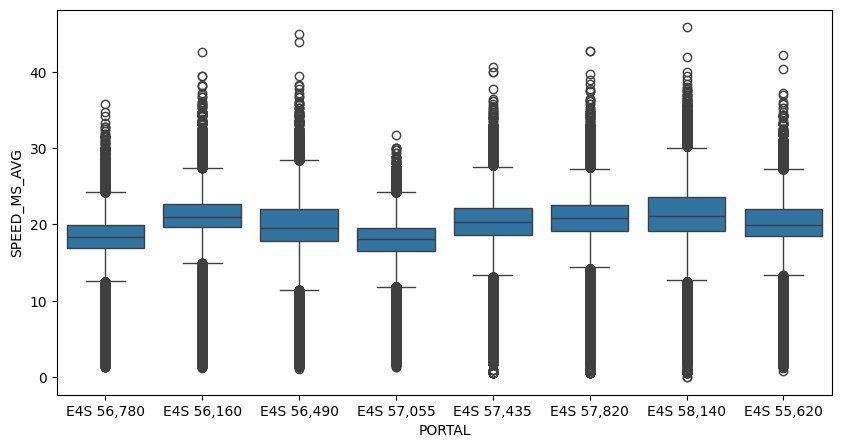

In [95]:
# speed per portal
plt.figure(figsize=(10,5))
sns.boxplot(x='PORTAL', y='SPEED_MS_AVG', data=df)
plt.savefig("Plots/Speed/boxplot_portal.eps")  
plt.savefig("Plots/Speed/boxplot_portal.png")  
plt.show()

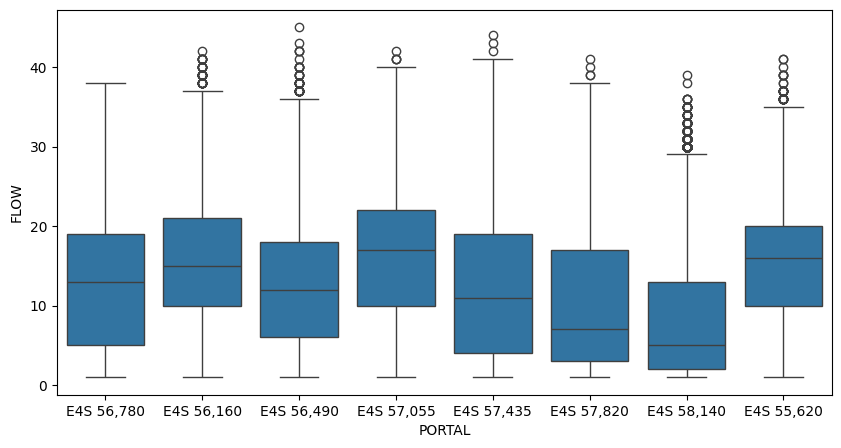

In [96]:
#flow per portal
plt.figure(figsize=(10,5))
sns.boxplot(x='PORTAL', y='FLOW', data=df)
plt.savefig("Plots/Flow/boxplot_portal.eps")  
plt.savefig("Plots/Flow/boxplot_portal.png")  
plt.show()


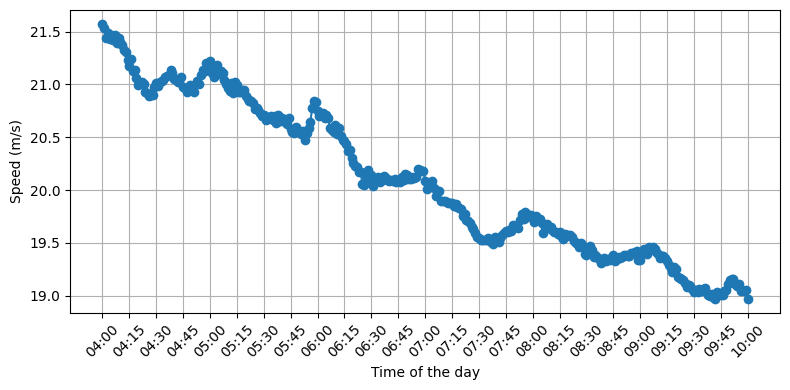

In [97]:
#speed over day
speed_overday = df.groupby('Time_only')['SPEED_MS_AVG'].mean().reset_index()
speed_overday['Time_str'] = speed_overday['Time_only'].apply(lambda t: t.strftime('%H:%M'))
plt.figure(figsize=(8, 4))
plt.plot(speed_overday['Time_str'], speed_overday['SPEED_MS_AVG'], marker='o')
plt.xlabel('Time of the day')
plt.ylabel('Speed (m/s)')
plt.xticks(speed_overday['Time_str'][::15], rotation=90)  #plot time only every 15 mins
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Plots/Speed/avg_speed_day.eps")  
plt.savefig("Plots/Speed/avg_speed_day.png")  
plt.show()

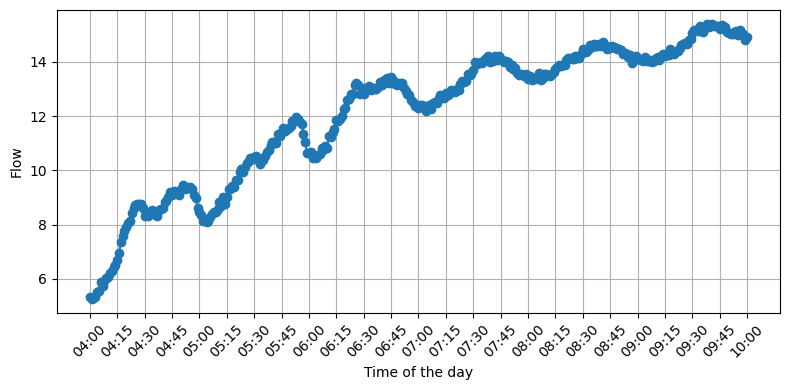

In [98]:
#flow over day
flow_overday = df.groupby('Time_only')['FLOW'].mean().reset_index()
flow_overday['Time_str'] = flow_overday['Time_only'].apply(lambda t: t.strftime('%H:%M'))
plt.figure(figsize=(8, 4))
plt.plot(flow_overday['Time_str'], flow_overday['FLOW'], marker='o')
plt.xlabel('Time of the day')
plt.ylabel('Flow')
plt.xticks(flow_overday['Time_str'][::15], rotation=90)  #plot time only every 15 mins
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Plots/Flow/avg_flow_day.eps")  
plt.savefig("Plots/Flow/avg_flow_day.png")  

plt.show()

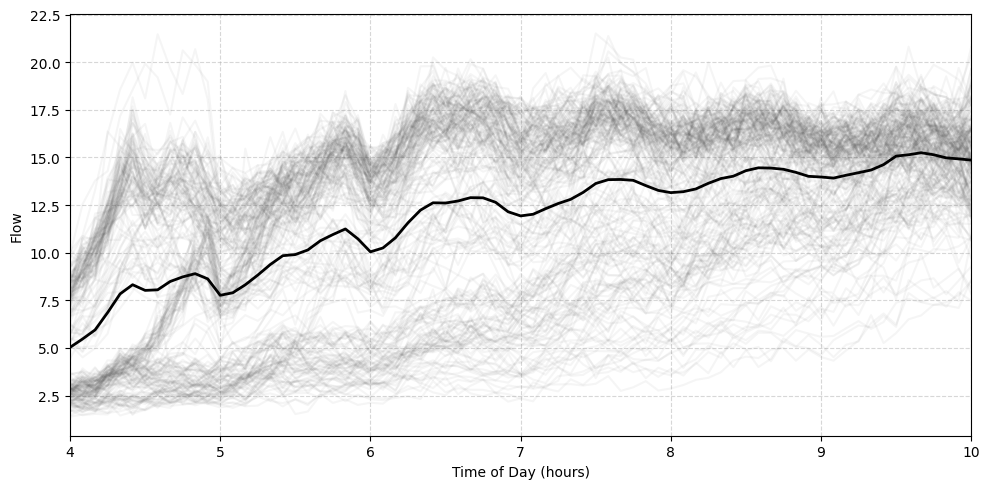

In [99]:
#graph over day (
df_graph=df.copy()
df_graph['Minutes'] = df_graph['Datetime'].dt.hour * 60 + df_graph['Datetime'].dt.minute
df_graph['Minutes_5'] = (df_graph['Minutes'] // 5) * 5
flow_matrix = df_graph.pivot_table(index='Date_only', columns='Minutes_5', values='FLOW', aggfunc='mean')
#flow_matrix = df_graph.pivot_table(index='Date_only', columns='Minutes_5', values='SPEED_MS_AVG', aggfunc='mean')

x_axis_hours = np.array(flow_matrix.columns) / 60
vectorized_day_dataset = flow_matrix.values
ndays = vectorized_day_dataset.shape[0]

#Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.array([x_axis_hours]*ndays).T, vectorized_day_dataset.T, color='#444444', alpha=0.05)
ax.plot(x_axis_hours, np.nanmean(vectorized_day_dataset, axis=0), color='black', linewidth=2)
ax.set_ylabel('Flow') 
#ax.set_ylabel('Speed')
ax.set_xlabel('Time of Day (hours)')
ax.set_xlim(4, 10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Plots/Flow/daily_profile.png")
#plt.savefig("Plots/Speed/daily_profile.png")
plt.show()


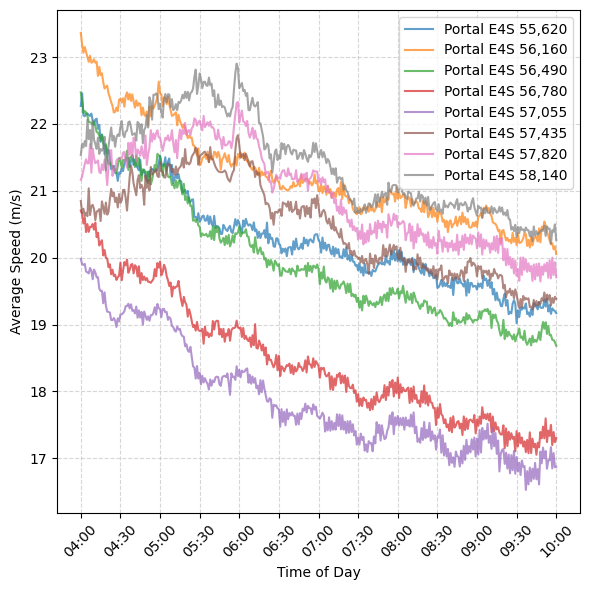

In [100]:
#over day per per portal
plt.figure(figsize=(6,6))
df_avg = df.groupby(['PORTAL', 'Time_only'])['SPEED_MS_AVG'].mean().reset_index()
df_avg['Time_str'] = df_avg['Time_only'].apply(lambda t: t.strftime('%H:%M'))

# Plot pper Portal
for portal in df_avg['PORTAL'].unique():
    df_portal = df_avg[df_avg['PORTAL'] == portal]
    plt.plot(df_portal['Time_str'], df_portal['SPEED_MS_AVG'], label=f'Portal {portal}', alpha=0.7)

plt.xlabel("Time of Day")
plt.ylabel("Average Speed (m/s)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(flow_overday['Time_str'][::30], rotation=45)  #plot time only every 15 mins
plt.tight_layout()
plt.savefig("Plots/Speed/speed_comparison_portals.png")
plt.show()


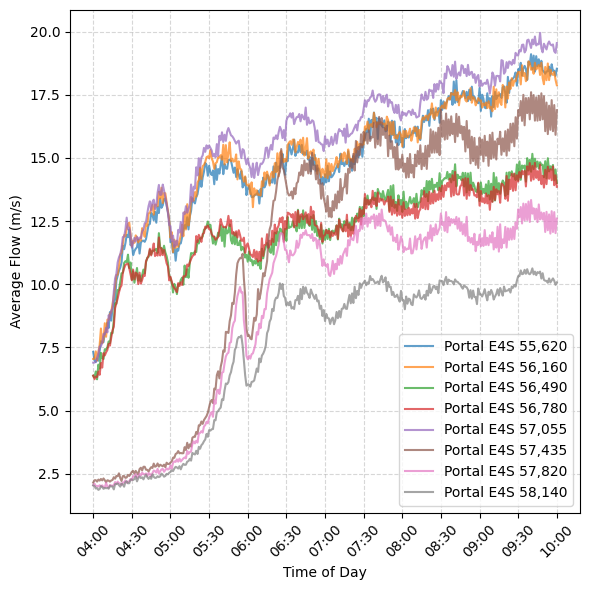

In [101]:
#flow per portal over day
plt.figure(figsize=(6,6))
df_avg = df.groupby(['PORTAL', 'Time_only'])['FLOW'].mean().reset_index()
df_avg['Time_str'] = df_avg['Time_only'].apply(lambda t: t.strftime('%H:%M'))

# Plot per Portal
for portal in df_avg['PORTAL'].unique():
    df_portal = df_avg[df_avg['PORTAL'] == portal]
    plt.plot(df_portal['Time_str'], df_portal['FLOW'], label=f'Portal {portal}', alpha=0.7)

plt.xlabel("Time of Day")
plt.ylabel("Average Flow (m/s)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(flow_overday['Time_str'][::30], rotation=45)  #plot time only every 15 mins
plt.tight_layout()
plt.savefig("Plots/Flow/flow_comparison_portals.png")
plt.show()


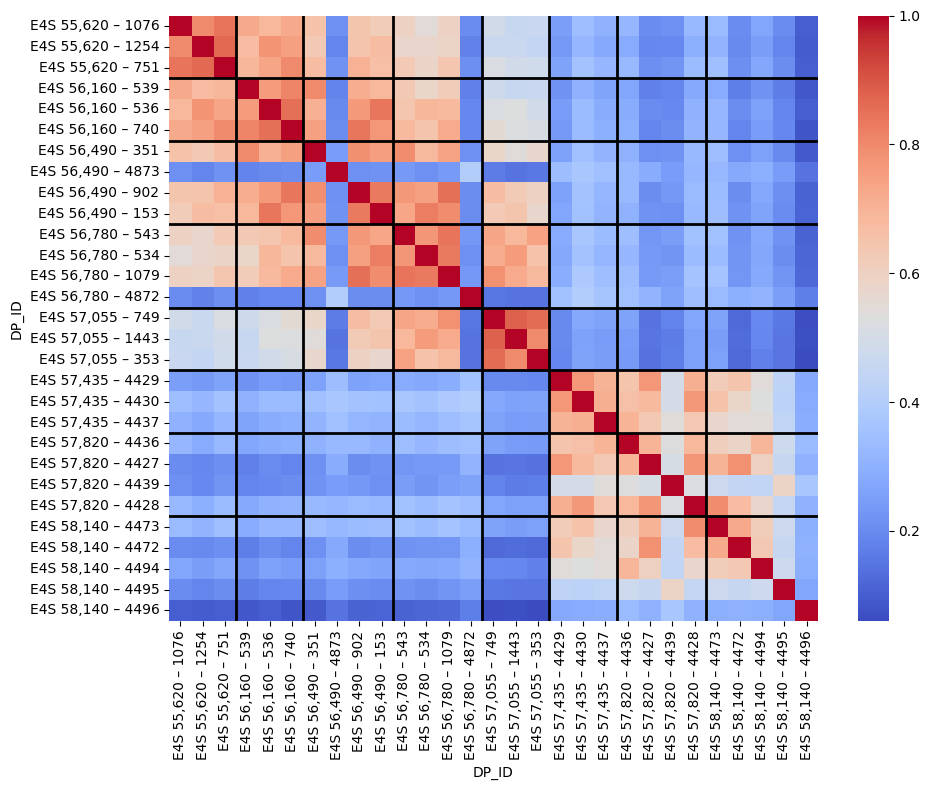

In [102]:
sensor_portal_map = df[['DP_ID', 'PORTAL']].drop_duplicates().set_index('DP_ID')['PORTAL']
# correlation matrix
df_corr = df.pivot_table(
    index='Datetime', columns='DP_ID', values='SPEED_MS_AVG'
)
corr_matrix = df_corr.corr()

sorted_sensors = sensor_portal_map.sort_values().index.tolist()
corr_sorted = corr_matrix.loc[sorted_sensors, sorted_sensors]

portal_groups = sensor_portal_map.loc[sorted_sensors]
portal_boundaries = []

last_portal = portal_groups.iloc[0]
for i, portal in enumerate(portal_groups):
    if portal != last_portal:
        portal_boundaries.append(i)
        last_portal = portal

plt.figure(figsize=(10, 8))

labels = [f"{sensor_portal_map[dp_id]} – {dp_id}" for dp_id in sorted_sensors]

sns.heatmap(corr_sorted, cmap='coolwarm', annot=False, xticklabels=labels, yticklabels=labels)

for boundary in portal_boundaries:
    plt.axhline(boundary, color='black', linewidth=2)
    plt.axvline(boundary, color='black', linewidth=2)

plt.tight_layout()
plt.savefig("Plots/Speed/sensor_corr_by_portal.eps")
plt.savefig("Plots/Speed/sensor_corr_by_portal.png")

plt.show()


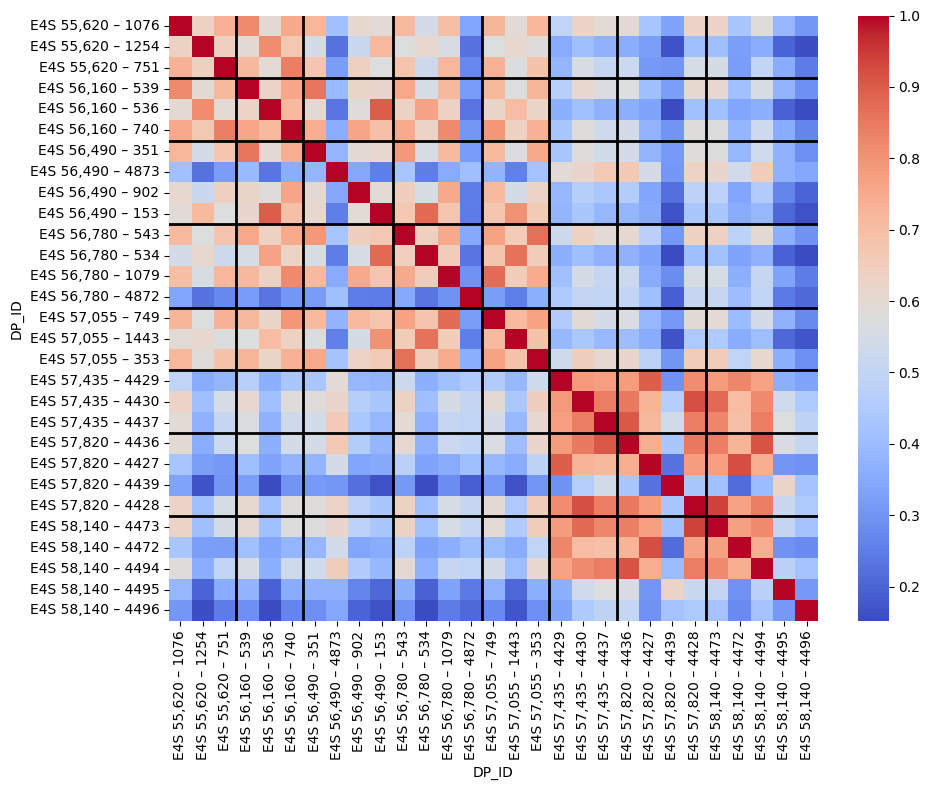

In [103]:
sensor_portal_map = df[['DP_ID', 'PORTAL']].drop_duplicates().set_index('DP_ID')['PORTAL']


# correlation matrix
df_corr = df.pivot_table(
    index='Datetime', columns='DP_ID', values='FLOW'
)
corr_matrix = df_corr.corr()

sorted_sensors = sensor_portal_map.sort_values().index.tolist()
corr_sorted = corr_matrix.loc[sorted_sensors, sorted_sensors]

portal_groups = sensor_portal_map.loc[sorted_sensors]
portal_boundaries = []

last_portal = portal_groups.iloc[0]
for i, portal in enumerate(portal_groups):
    if portal != last_portal:
        portal_boundaries.append(i)
        last_portal = portal

plt.figure(figsize=(10, 8))

labels = [f"{sensor_portal_map[dp_id]} – {dp_id}" for dp_id in sorted_sensors]

sns.heatmap(corr_sorted, cmap='coolwarm', annot=False, xticklabels=labels, yticklabels=labels)

for boundary in portal_boundaries:
    plt.axhline(boundary, color='black', linewidth=2)
    plt.axvline(boundary, color='black', linewidth=2)

plt.tight_layout()
plt.savefig("Plots/Flow/sensor_corr_by_portal.eps")
plt.savefig("Plots/Flow/sensor_corr_by_portal.png")

plt.show()


Clustering sensors for lane identification

In [104]:
df_clustering=df.copy()


#uncomment these lines
selected_portals = ['55620', '56160','56490','56780','57055']
#selected_portals = ['57435','57820','58140']

df_clustering = df_clustering[df_clustering['PORTAL_clean'].isin(selected_portals)]



import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

df_speed = df_clustering.pivot_table(index="Datetime", columns="DP_ID", values="SPEED_MS_AVG")
df_flow  = df_clustering.pivot_table(index="Datetime", columns="DP_ID", values="FLOW")

df_merged = pd.concat({"speed": df_speed, "flow": df_flow}, axis=1)
df_merged = df_merged.dropna()

X_list = []
sensor_ids = df_speed.columns

scaler_speed = MinMaxScaler()
scaler_flow = MinMaxScaler()

for sid in sensor_ids:
    speed_series = df_merged[("speed", sid)].values.reshape(-1, 1)
    flow_series  = df_merged[("flow", sid)].values.reshape(-1, 1)

    speed_scaled = scaler_speed.fit_transform(speed_series).flatten()
    flow_scaled  = scaler_flow.fit_transform(flow_series).flatten()

    sensor_vector = np.concatenate([speed_scaled, flow_scaled])
    X_list.append(sensor_vector)

X = pd.DataFrame(X_list, index=sensor_ids)


In [105]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X)


clusters = pd.DataFrame({
    "Sensor": sensor_ids,
    "Portal": [sensor_to_portal[s] for s in sensor_ids],
    "Cluster": labels
}).sort_values("Portal")

from sklearn.metrics import silhouette_score
score = silhouette_score(X, labels)
print("Silhouette Score:", round(score, 3))

print(clusters)
clusters.groupby("Portal")["Cluster"].value_counts().unstack(fill_value=0)
    


Silhouette Score: 0.234
    Sensor Portal  Cluster
13    1254  55620        2
11    1076  55620        0
9      751  55620        3
4      536  56160        2
5      539  56160        0
7      740  56160        3
0      153  56490        2
10     902  56490        3
16    4873  56490        1
1      351  56490        0
6      543  56780        0
3      534  56780        2
12    1079  56780        3
15    4872  56780        1
2      353  57055        0
14    1443  57055        2
8      749  57055        3


Cluster,0,1,2,3
Portal,,,,
55620,1,0,1,1
56160,1,0,1,1
56490,1,1,1,1
56780,1,1,1,1
57055,1,0,1,1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


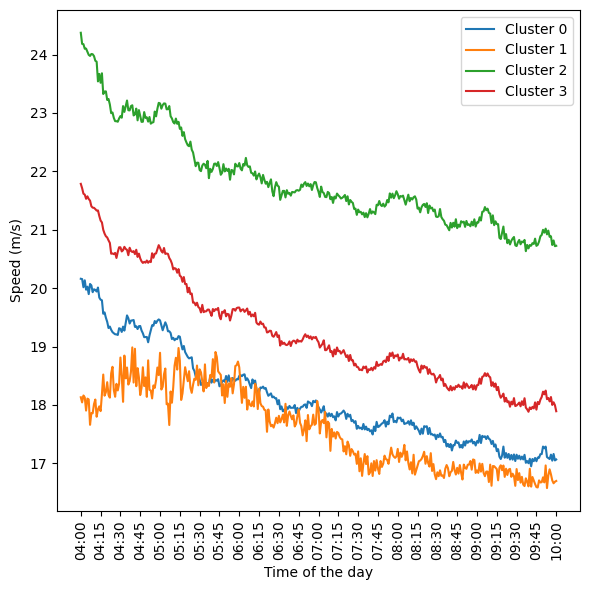

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


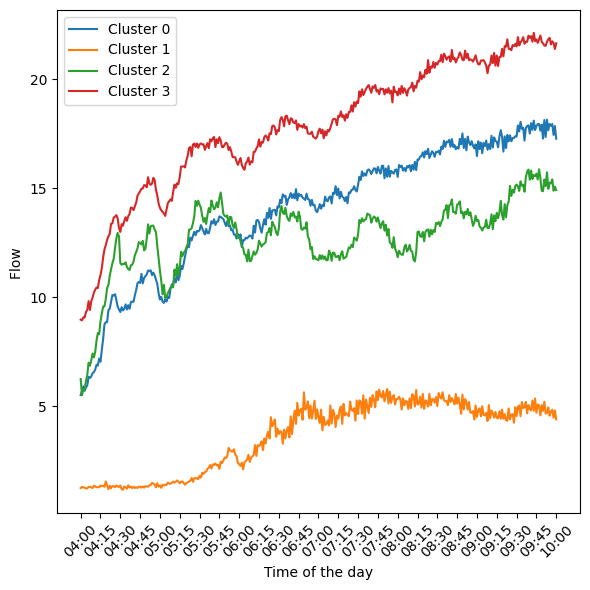

In [106]:
sensor_to_cluster = dict(zip(sensor_ids, labels))
df_clustering["Cluster"] = df_clustering["DP_ID"].map(sensor_to_cluster)
speed_profile = df_clustering.groupby(["Time_only", "Cluster"])["SPEED_MS_AVG"].mean().unstack()
speed_profile.index = speed_profile.index.map(lambda t: t.strftime('%H:%M'))


flow_profile  = df_clustering.groupby(["Time_only", "Cluster"])["FLOW"].mean().unstack()
flow_profile.index  = flow_profile.index.map(lambda t: t.strftime('%H:%M'))

import matplotlib.pyplot as plt

# SPEED
plt.figure(figsize=(6, 6))
for cid in speed_profile.columns:
    plt.plot(speed_profile.index, speed_profile[cid], label=f"Cluster {cid}")
plt.xticks(speed_profile.index[::15], rotation=90)  #plot time only every 15 mins

plt.xlabel("Time of the day")
plt.ylabel("Speed (m/s)")
plt.legend()
plt.tight_layout()
plt.savefig("Plots/Speed/clustering_5portals.eps")
plt.savefig("Plots/Speed/clustering_5portals.png")

#plt.savefig("Plots/Speed/clustering_3portals.eps")
#plt.savefig("Plots/Speed/clustering_3portals.png")

plt.show()

# FLOW
plt.figure(figsize=(6, 6))
for cid in flow_profile.columns:
    plt.plot(flow_profile.index, flow_profile[cid], label=f"Cluster {cid}")
plt.xlabel("Time of the day")
plt.xticks(flow_profile.index[::15], rotation=90)  #plot time only every 15 mins

plt.ylabel("Flow ")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("Plots/Flow/clustering_5portals.eps")
plt.savefig("Plots/Flow/clustering_5portals.png")

#plt.savefig("Plots/Flow/clustering_3portals.eps")
#plt.savefig("Plots/Flow/clustering_3portals.png")


plt.show()


## cluster 2 probably left lane: 
## cluster 3 probably middle lane: 
# cluster 0  probably right lane and
#cluster 1 probably to and from flow 

Portal 55620 and 56160

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


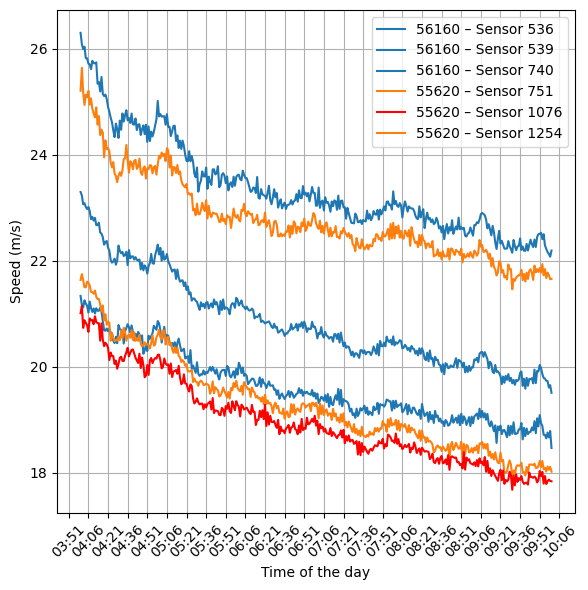

In [107]:
speed_sensors = (
    df.groupby(['DP_ID', 'Time_only', 'PORTAL_clean'])['SPEED_MS_AVG']
      .mean()
      .reset_index()
)


speed_sensors['Time_dt'] = pd.to_datetime(speed_sensors['Time_only'].astype(str), format='%H:%M:%S')


##uncomment these lines for seeing all portal
selected_portals = ['55620', '56160']
speed_sensors = speed_sensors[speed_sensors['PORTAL_clean'].isin(selected_portals)]

portal_colors = dict(zip(
    speed_sensors['PORTAL_clean'].unique(),
    sns.color_palette('tab10', n_colors=speed_sensors['PORTAL_clean'].nunique())
))

# Plot
plt.figure(figsize=(6, 6))

for dp_id, group in speed_sensors.groupby('DP_ID'):
    portal = group['PORTAL_clean'].iloc[0]
    color = 'red' if dp_id == 1076 else portal_colors[portal]
    plt.plot(group['Time_dt'], group['SPEED_MS_AVG'],
             linewidth=1.5, label=f'{portal} – Sensor {dp_id}', color=color)

# format axis
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=15))

plt.xlabel('Time of the day')
plt.xticks(rotation=45)  # ever<y 15 mins 

plt.ylabel('Speed (m/s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Plots/Speed/avg_speed_day_per_sensor_portal.eps")
plt.savefig("Plots/Speed/avg_speed_day_per_sensor_portal.png")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


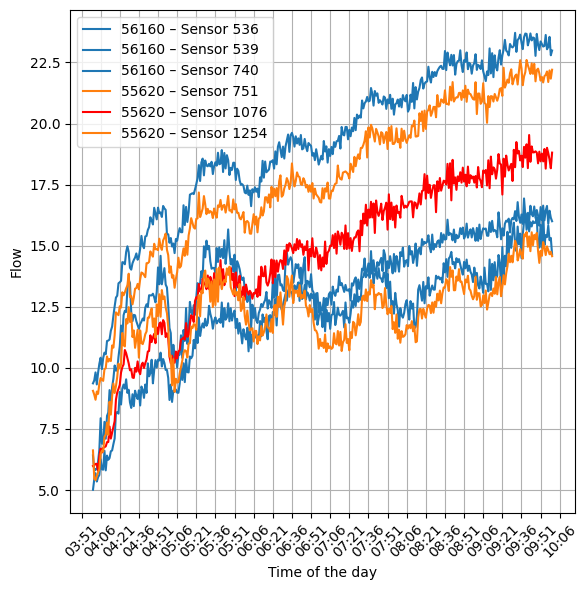

In [108]:
flow_sensors = (
    df.groupby(['DP_ID', 'Time_only', 'PORTAL_clean'])['FLOW']
      .mean()
      .reset_index()
)


flow_sensors['Time_dt'] = pd.to_datetime(flow_sensors['Time_only'].astype(str), format='%H:%M:%S')


##uncomment these lines for seeing all portal
selected_portals = ['55620', '56160']
flow_sensors = flow_sensors[flow_sensors['PORTAL_clean'].isin(selected_portals)]

portal_colors = dict(zip(
    flow_sensors['PORTAL_clean'].unique(),
    sns.color_palette('tab10', n_colors=flow_sensors['PORTAL_clean'].nunique())
))

# Plot
plt.figure(figsize=(6, 6))

for dp_id, group in flow_sensors.groupby('DP_ID'):
    portal = group['PORTAL_clean'].iloc[0]
    color = 'red' if dp_id == 1076 else portal_colors[portal]
    plt.plot(group['Time_dt'], group['FLOW'],
             linewidth=1.5, label=f'{portal} – Sensor {dp_id}', color=color)

# Achse formatieren
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=15))

plt.xlabel('Time of the day')
plt.xticks(rotation=45)  # ever<y 15 mins 

plt.ylabel('Flow')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Plots/Flow/avg_flow_day_per_sensor_portal.eps")
plt.savefig("Plots/Flow/avg_flow_day_per_sensor_portal.png")

Data preprocessing

In [109]:
df_2 = df[df["PORTAL_clean"].isin(['55620', '56160'])]
print(df_2.shape)
df_2.head()

(434150, 13)


,DP_ID,PORTAL,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Datetime,Time_only,Date_only,PORTAL_clean
1,539,"E4S 56,160",240,48,16,8,4,19.64,9.0,2021-06-01 04:00:00,04:00:00,2021-06-01,56160
5,536,"E4S 56,160",240,48,16,8,4,28.35,2.0,2021-06-01 04:00:00,04:00:00,2021-06-01,56160
17,751,"E4S 55,620",240,48,16,8,4,21.53,19.0,2021-06-01 04:00:00,04:00:00,2021-06-01,55620
18,740,"E4S 56,160",240,48,16,8,4,21.99,17.0,2021-06-01 04:00:00,04:00:00,2021-06-01,56160
21,1254,"E4S 55,620",240,48,16,8,4,24.53,4.0,2021-06-01 04:00:00,04:00:00,2021-06-01,55620


DP_ID
536     4923
539      775
740      306
751      152
1076     399
1254    5413
dtype: int64


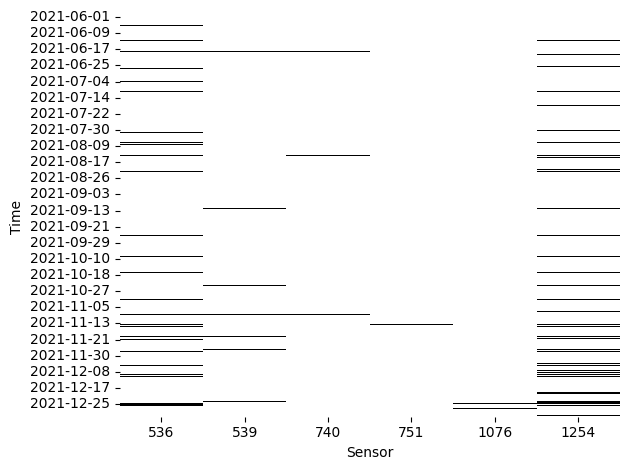

In [110]:
df_pivot = df_2.pivot(index='Datetime', columns='DP_ID', values='SPEED_MS_AVG')
print(df_pivot.isna().sum())
sns.heatmap(df_pivot.isna(), cbar=False, cmap='gray_r')
plt.xlabel("Sensor")
plt.ylabel("Time")
tick_positions = np.arange(0, len(df_pivot.index), 3000)
tick_labels = df_pivot.index[tick_positions].strftime("%Y-%m-%d")

plt.yticks(tick_positions, tick_labels, rotation=0)
plt.tight_layout()
plt.savefig("Plots/missingvalues.eps")
plt.savefig("Plots/missingvalues.png")
plt.show()


In [111]:
available_days = df_2['Date_only'].drop_duplicates().sort_values()
print(len(available_days))
start_time = datetime.strptime("04:00", "%H:%M").time()
end_time = datetime.strptime("10:00", "%H:%M").time()

available_times = []

for day in available_days:
    current = datetime.combine(day, start_time)
    end = datetime.combine(day, end_time)
    while current <= end:
        available_times.append(current)
        current += timedelta(minutes=1)

available_times = pd.to_datetime(available_times)


211


In [112]:
portal_sensors = df_2['DP_ID'].unique()
full_index = pd.MultiIndex.from_product([available_times, portal_sensors], names=['Datetime', 'DP_ID'])
df_2_full = pd.DataFrame(index=full_index).reset_index()
df_2_full = pd.merge(df_2_full, df_2, on=['Datetime', 'DP_ID'], how='left')
portal_map = df_2.dropna(subset=['PORTAL_clean','PORTAL'])[['DP_ID', 'PORTAL_clean','PORTAL']].drop_duplicates().set_index('DP_ID')

df_2_full['Interval_1'] = np.floor((df_2_full['Datetime'].dt.hour * 60 + df_2_full['Datetime'].dt.minute) / 1).astype(int)#df_2_full['Datetime'].map(interval_map['Interval_1'])
df_2_full['Interval_5'] = np.floor((df_2_full['Datetime'].dt.hour * 60 + df_2_full['Datetime'].dt.minute) / 5).astype(int)#df_2_full['Datetime'].map(interval_map['Interval_5'])
df_2_full['Interval_15'] = np.floor((df_2_full['Datetime'].dt.hour * 60 + df_2_full['Datetime'].dt.minute) / 15).astype(int) #df_2_full['Datetime'].map(interval_map['Interval_15'])
df_2_full['Interval_30'] = np.floor((df_2_full['Datetime'].dt.hour * 60 + df_2_full['Datetime'].dt.minute) / 30).astype(int) #df_2_full['Datetime'].map(interval_map['Interval_30'])
df_2_full['Interval_60'] = np.floor((df_2_full['Datetime'].dt.hour * 60 + df_2_full['Datetime'].dt.minute) / 60).astype(int) #df_2_full['Datetime'].map(interval_map['Interval_60'])

df_2_full['PORTAL_clean'] = df_2_full['DP_ID'].map(portal_map['PORTAL_clean'])
df_2_full['PORTAL'] = df_2_full['DP_ID'].map(portal_map['PORTAL'])

df_2_full['Time_only'] = df_2_full['Datetime'].dt.time
df_2_full['Date_only']=df_2_full['Datetime'].dt.date#


print(df_2_full.isna().sum())

df_2_full.head()

Datetime            0
DP_ID               0
PORTAL              0
Interval_1          0
Interval_5          0
Interval_15         0
Interval_30         0
Interval_60         0
SPEED_MS_AVG    22876
FLOW            22876
Time_only           0
Date_only           0
PORTAL_clean        0
dtype: int64


,Datetime,DP_ID,PORTAL,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Time_only,Date_only,PORTAL_clean
0,2021-06-01 04:00:00,539,"E4S 56,160",240,48,16,8,4,19.64,9.0,04:00:00,2021-06-01,56160
1,2021-06-01 04:00:00,536,"E4S 56,160",240,48,16,8,4,28.35,2.0,04:00:00,2021-06-01,56160
2,2021-06-01 04:00:00,751,"E4S 55,620",240,48,16,8,4,21.53,19.0,04:00:00,2021-06-01,55620
3,2021-06-01 04:00:00,740,"E4S 56,160",240,48,16,8,4,21.99,17.0,04:00:00,2021-06-01,56160
4,2021-06-01 04:00:00,1254,"E4S 55,620",240,48,16,8,4,24.53,4.0,04:00:00,2021-06-01,55620


In [113]:
print(df_2_full["Time_only"].min(), df_2_full["Time_only"].max())
print(df["Date_only"].min(),df["Date_only"].max())

04:00:00 10:00:00
2021-06-01 2021-12-31


In [114]:
df_2_pivot_speed = df_2_full.pivot(index='Datetime', columns='DP_ID', values='SPEED_MS_AVG')
df_2_pivot_flow = df_2_full.pivot(index='Datetime', columns='DP_ID', values='FLOW')


df_2_pivot_speed = df_2_pivot_speed.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')
df_2_pivot_flow = df_2_pivot_flow.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')

df_speed_flat = df_2_pivot_speed.reset_index().melt(id_vars='Datetime', var_name='DP_ID', value_name='SPEED_MS_AVG_filled')
df_flow_flat = df_2_pivot_flow.reset_index().melt(id_vars='Datetime', var_name='DP_ID', value_name='FLOW_filled')

df_2_full = (
    df_2_full
    .merge(df_speed_flat, on=['Datetime', 'DP_ID'], how='left')
    .merge(df_flow_flat, on=['Datetime', 'DP_ID'], how='left')
)
print(df_2_full.shape)
print(df_2_full["Date_only"].nunique())

df_2_full.head()

C:\Users\Johanna\AppData\Local\Temp\ipykernel_17776\2862548527.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_2_pivot_speed = df_2_pivot_speed.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')
C:\Users\Johanna\AppData\Local\Temp\ipykernel_17776\2862548527.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_2_pivot_flow = df_2_pivot_flow.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')


(457026, 15)
211


,Datetime,DP_ID,PORTAL,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Time_only,Date_only,PORTAL_clean,SPEED_MS_AVG_filled,FLOW_filled
0,2021-06-01 04:00:00,539,"E4S 56,160",240,48,16,8,4,19.64,9.0,04:00:00,2021-06-01,56160,19.64,9.0
1,2021-06-01 04:00:00,536,"E4S 56,160",240,48,16,8,4,28.35,2.0,04:00:00,2021-06-01,56160,28.35,2.0
2,2021-06-01 04:00:00,751,"E4S 55,620",240,48,16,8,4,21.53,19.0,04:00:00,2021-06-01,55620,21.53,19.0
3,2021-06-01 04:00:00,740,"E4S 56,160",240,48,16,8,4,21.99,17.0,04:00:00,2021-06-01,56160,21.99,17.0
4,2021-06-01 04:00:00,1254,"E4S 55,620",240,48,16,8,4,24.53,4.0,04:00:00,2021-06-01,55620,24.53,4.0


In [115]:
print(df_2_full.isna().sum())
print(df_2_full["Date_only"].nunique())

Datetime                   0
DP_ID                      0
PORTAL                     0
Interval_1                 0
Interval_5                 0
Interval_15                0
Interval_30                0
Interval_60                0
SPEED_MS_AVG           22876
FLOW                   22876
Time_only                  0
Date_only                  0
PORTAL_clean               0
SPEED_MS_AVG_filled        0
FLOW_filled                0
dtype: int64
211


In [116]:
first_times = df_2_full.groupby(['Interval_15', 'DP_ID', 'PORTAL_clean'])['Datetime'].min().reset_index()
print(first_times.head(10))
df_2_agg = df_2_full.groupby(['Interval_15', 'DP_ID', 'PORTAL_clean']).agg({
    'SPEED_MS_AVG': 'mean',
    'FLOW': 'sum'
}).reset_index()
df_2_agg = df_2_agg.merge(first_times, on=['Interval_15', 'DP_ID', 'PORTAL_clean'], how='left')#
print(df_2_agg.head(10))

   Interval_15  DP_ID PORTAL_clean            Datetime
0           16    536        56160 2021-06-01 04:00:00
1           16    539        56160 2021-06-01 04:00:00
2           16    740        56160 2021-06-01 04:00:00
3           16    751        55620 2021-06-01 04:00:00
4           16   1076        55620 2021-06-01 04:00:00
5           16   1254        55620 2021-06-01 04:00:00
6           17    536        56160 2021-06-01 04:15:00
7           17    539        56160 2021-06-01 04:15:00
8           17    740        56160 2021-06-01 04:15:00
9           17    751        55620 2021-06-01 04:15:00
   Interval_15  DP_ID PORTAL_clean  SPEED_MS_AVG     FLOW            Datetime
0           16    536        56160     25.777339  14746.0 2021-06-01 04:00:00
1           16    539        56160     21.125469  17247.0 2021-06-01 04:00:00
2           16    740        56160     22.920332  31378.0 2021-06-01 04:00:00
3           16    751        55620     21.480825  29051.0 2021-06-01 04:00:00
4    

In [27]:
df_2_full.head()
df_2_full.to_parquet("data/processed/df_2_full_v2.parquet", index=False)
df_2_full_csv=df_2_full.drop(columns=["Date_only", "Time_only"])
df_2_full_csv.to_csv("data/processed/df_2_full_v2.csv", index=False,sep=";")

